In [153]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Importing Data

## Define Data Folders

In [154]:
parent_data_folder = "F:/Dropbox/Projects/001 - CNRL - Pipewise/005 - Field Test/2023/data"
#TEAC_raw_data_folder = parent_data_folder + "/TEAC/Raw Data/"
raw_test_name = parent_data_folder + "/data_2.csv"

In [155]:
# Calculate the total number of rows in the file (excluding the header)
with open(raw_test_name) as f:
    total_rows = sum(1 for _ in f) - 1

# Read the CSV file and create a pandas DataFrame, excluding the last row
data_frame = pd.read_csv(raw_test_name, nrows=total_rows - 1)

In [156]:
# Convert the time column to datetime objects
data_frame['time'] = pd.to_datetime(data_frame['time'])

In [157]:
# Calculate the relative time in seconds
data_frame['relative_time'] = (data_frame['time'] - data_frame['time'].iloc[0]).dt.total_seconds()

# Access the relative time column
time_values = data_frame['relative_time']


In [158]:
print(data_frame)

                             time  Channel 0  Channel 1  relative_time
0      2023-05-17 15:24:26.406388   0.184058   0.189906       0.000000
1      2023-05-17 15:24:26.406598   0.288914   0.295307       0.000210
2      2023-05-17 15:24:26.406641   0.267852   0.273633       0.000253
3      2023-05-17 15:24:26.406676   0.257601   0.261837       0.000288
4      2023-05-17 15:24:26.406709   0.236885   0.239920       0.000321
...                           ...        ...        ...            ...
134235 2023-05-17 15:24:39.611629  -0.032795  -0.028089      13.205241
134236 2023-05-17 15:24:39.611660  -0.035111  -0.030631      13.205272
134237 2023-05-17 15:24:39.611691  -0.013796  -0.007508      13.205303
134238 2023-05-17 15:24:39.611722  -0.000478   0.007196      13.205334
134239 2023-05-17 15:24:39.611755  -0.010306  -0.002764      13.205367

[134240 rows x 4 columns]


## Shape into Dataframe

# Meta Validation

### Maximum, minimums and average

In [159]:
# Calculate the maximum, minimum, and average values
max_values = data_frame.max()
min_values = data_frame.min()
average_values = data_frame.mean()

# Create a DataFrame with the results
stats_df = pd.DataFrame({'Maximum': max_values, 'Minimum': min_values, 'Average': average_values})

# Round the values to 1 decimal place
stats_df_rounded = stats_df.round(1)

# Display the results in a tabular format
print(stats_df_rounded)

# Note: values of 0.0 indicate that - most likely - the channel was not used

                                  Maximum                     Minimum  Average
Channel 0                        0.305401                   -0.111002      0.0
Channel 1                        0.301018                   -0.091534      0.0
relative_time                   13.205367                         0.0      6.6
time           2023-05-17 15:24:39.611755  2023-05-17 15:24:26.406388      NaN


C:\Users\0\AppData\Local\Temp\ipykernel_6044\3974125766.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_values = data_frame.mean()


### Data Points & Recording Time

In [160]:
# Access the first column using its index and count the number of data points
#time_values = data_frame.iloc[:, 0]
data_points_count = time_values.count()

# Workaround to account for files that don't start at 0 seconds
initial_recording_time = time_values.iloc[0]
final_recording_time = time_values.iloc[-1]
delta_recording_time = final_recording_time - initial_recording_time

print("Number of data points in the first column:", data_points_count)
print("Data was recorded for", round(delta_recording_time,2), "seconds")
print("Data was recorded for", round(delta_recording_time/60,2), "minutes")
print("Data was recorded for", round(delta_recording_time/3600,2), "hours")

Number of data points in the first column: 134240
Data was recorded for 13.21 seconds
Data was recorded for 0.22 minutes
Data was recorded for 0.0 hours


### Sampling rate, Consistency and CV

In [161]:
# Calculate the time differences between consecutive data points
time_differences = time_values.diff().dropna()

# Define the expected sampling rate (in Hz) and maximum allowed deviation (in percentage)
expected_sampling_rate = 10240  # Replace with your expected sampling rate
max_allowed_deviation = 0.05  # 5% deviation, for example

# Calculate the expected time difference between consecutive data points
expected_time_difference = 1 / expected_sampling_rate

# Calculate the deviation of each time difference from the expected time difference
deviation = np.abs(time_differences - expected_time_difference)

# Count the number of time intervals that exceed the maximum allowed deviation
exceed_threshold_count = np.sum(deviation > max_allowed_deviation * expected_time_difference)

# Calculate the percentage of time intervals that exceed the maximum allowed deviation
exceed_threshold_percentage = exceed_threshold_count / len(time_differences) * 100

# Calculate the effective sampling rate
effective_sampling_rate = 1 / time_differences.mean()

print(f"Expected sampling rate: {expected_sampling_rate} Hz")
print(f"Effective sampling rate: {effective_sampling_rate:.2f} Hz")
print(f"Number of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_count}")
print(f"Percentage of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_percentage:.2f}%")

Expected sampling rate: 10240 Hz
Effective sampling rate: 10165.49 Hz
Number of time intervals exceeding 5.0% deviation: 133807
Percentage of time intervals exceeding 5.0% deviation: 99.68%


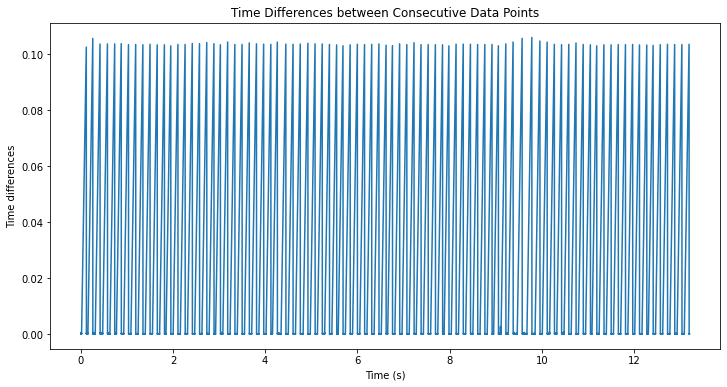

In [167]:
import matplotlib.pyplot as plt

# Remove the first value from time_values to match the length of time_differences
adjusted_time_values = time_values.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(adjusted_time_values, time_differences)
plt.xlabel("Time (s)")
plt.ylabel("Time differences")
plt.title("Time Differences between Consecutive Data Points")
plt.show()

# Signal

Plots a single channel against time. Note: To plot a full test length takes a significant amount of time

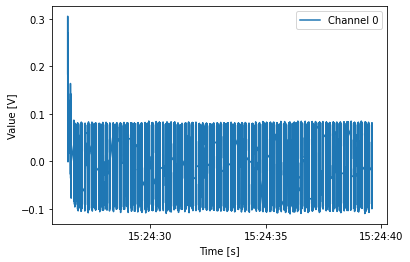

In [170]:

device_data = data_frame[["Channel 0"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(data_frame['time'], device_data[column], label=column)

#plt.xlim((1, 14))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
#plt.title('D1 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


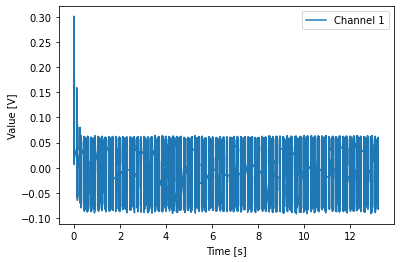

In [164]:

device_data = data_frame[["Channel 1"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(time_values, device_data[column], label=column)

#plt.xlim((100, 120))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
#plt.title('D1 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()
